In [1]:
import pde
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import Video


In [9]:
## POTENTIAL DEFINITION ##

## PARAMETERS

m = 1 # fixed 
w = 1 # fixed 
x_s = 2*np.sqrt(2) # local minima positions +/- , change to vary barrier length
d_c = m*w**2/(2*x_s) # critical value of d 
d = -0.01 # modulates maximum position and barrier height, negative values -> global minimun on the right 
# d = 0 symmetric d!=0 asymmetric

hbar= 1
gamma = 100
beta = 1
lambda_ = (hbar/(np.pi*m*gamma))*np.log(hbar*beta*gamma/(2*np.pi))

print(lambda_, '>>', 1/(m*beta*gamma**2))
print(1/beta, '<<',  hbar*gamma)

if (d <= -d_c or d >= d_c):
    # d must be lower in absolute value than the critical value
    raise ValueError()

C = m*w**2/(8*x_s**2)
x_u = d*(2*x_s**2/(m*w**2)) # maximum position
delta_V = 4*d*x_s**3/3 # between the two minima 



def V(x):
    return C*(x**2-x_s**2)**2 - d*(x**3/3-x_s**2*x)

def V0(x): # rescale potential so that Vmax is at zero
    return V(x)-V(x_u)

def V_eff(x):
    return C*x**4-d/3*x**3+(-2*C*x_s**2+0.5*lambda_*12*C)*x**2+(d*x_s**2-0.5*lambda_*2*d)*x

def D_eff(x):
    return 1/beta*(1+lambda_*beta*(12*C*x**2-2*d*x-4*C*x_s**2))

print('barrier height', V(x_u)-V(-x_s))
print('max position', x_u)
print('delta V', delta_V)

x = np.linspace(-10,10,1000)

plt.plot(x,V0(x))
plt.ylim(V0(x_s)*1.1, 1)
plt.xlabel('x')
plt.ylabel(r'$V_0(x)$')

V(x_u)



0.008808567579302977 >> 0.0001
1.0 << 100
barrier height 0.8555471400135367
max position -0.16000000000000003
delta V -0.3016988933062604


<IPython.core.display.Javascript object>

1.0063965866666669

In [21]:
V_true_coeff = np.array([-0.76296297, -0.08380526,  0.2074074 ,  0.02095131, -0.06296296,
       -0.00130946,  0.00416667])
V_true_coeff = V_true_coeff[::-1]

V_true = np.poly1d(V_true_coeff)

In [10]:
plt.plot(x,V_eff(x))
plt.plot(x,D_eff(x))
plt.ylim(-1.5,2)


<IPython.core.display.Javascript object>

(-1.5, 2.0)

In [11]:
hbar = 1                   # reduced plank constant
x0 = -x_s                 # center of initial gaussian wave-packet, start on left minima
p0 = 0                     # momentum of initial gaussian wave-packet
mu = 0.1                   # mu = <delta_(x**2)>
alpha = 0                  # alpha = <delta_x*delta_p + delta_x*delta_p>


# gamma = 25
# beta = 1
# lambda_ = (hbar/(np.pi*m*gamma))*np.log(hbar*beta*gamma/(2*np.pi))

print(lambda_, 1/(m*beta*gamma**2), lambda_/(1/(m*beta*gamma**2)))
print(1/beta, hbar*gamma)
                                        
#((laplace(V(x))+0.5*{lambda_}laplace(laplace(V(x))))*(rho)+(d_dx(V(x))+0.5*{lambda_}*d_dx(laplace(rho)))*(d_dx(rho)) + ({lambda_}*laplace(laplace(V(x))))*rho+2*lambda_*d_dx(laplace(V(x)))*d_dx(V(x))+(1/{beta}+{lambda_}*laplace(V(x)))*laplace(rho))/({gamma}*{m})             


f_name = f'test.h5'
path = './Data/Simulations/'
movie_name = f'test.mov'
movie_path = './Data/Movie/'

# eq = pde.PDE({'rho':f'((laplace(V(x))+1*{lambda_}*laplace(laplace(V(x))))*rho + (2*{lambda_}*d_dx(laplace(V(x)))+d_dx(V(x)))*(d_dx(rho)) + (1/{beta}+{lambda_}*laplace(V(x)))*(laplace(rho)))/({gamma}*{m})'},user_funcs={'V':V})
eq = pde.PDE({'rho':f'(d_dx(d_dx(V_eff(x))*rho)+laplace(D_eff(x)*rho))/({gamma}*{m})'},user_funcs={'V_eff':V_eff, 'D_eff':D_eff})

## DEFINE SPATIAL GRID ##

Nx = 1000 # number of spatial points
x_left = -10
x_right = 10

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)

dx = grid.discretization
x = grid.cell_coords.flatten()

## DEFINE INITIAL STATE ##

# squeezed coherent Gaussian wavepacket 
rho0 = np.abs(1/((2*np.pi*mu)**0.25) * np.exp(-((1-1j*alpha)/(4*mu))*(x-x0)**2 + 1j*p0*(x-x0)/hbar))**2
initial_state = pde.ScalarField(grid=grid, data=rho0, label=r"$\rho_0$")
initial_state.plot() # TODO: ADD LABELS 

print("Total Probability: ", np.sum(initial_state.data*dx))

0.008808567579302977 0.0001 88.08567579302976
1.0 100


<IPython.core.display.Javascript object>

Total Probability:  1.0


In [12]:
## SOLVE EQUATION ##

# define storage 
storage = pde.MemoryStorage() # for movie
file_storage = pde.FileStorage(filename=path+f_name) # dataset

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 10000
dt_sim = 1e-2

# points to store to file
# N_t_writing = 1000 # can be changed if more points are needed
dt_writing = 0.01

# points to use in animation 
N_t_anim = 1000 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim), file_storage.tracker(interval=dt_writing)])
_ = controller.run(initial_state, dt=dt_sim)



  0%|          | 0/10000.0 [00:00<?, ?it/s]

Spent more time on handling trackers (463.328125) than on the actual simulation (38.53125)


In [13]:
## APPEND X DATA TO CREATED FILE ## 

file = h5py.File(path+f_name, 'a')
file.create_dataset('x', data=x)
file.close()

In [14]:
## PLOT SOLUTIONS ##

pde.plot_kymograph(storage)

<IPython.core.display.Javascript object>

In [16]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [17]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality, not working on deepnote
%matplotlib nbagg

simulation = storage.data
times = storage.times

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel('a.u.')
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, V0(x), "k--", label="V(x)")
line2, = ax.plot(x, np.abs(simulation[0]), "b", label=r"$\rho$")
plt.legend(loc=1, fontsize=8, fancybox=False)
plt.ylim(1.05*V0(x_s), np.max(np.abs(simulation))*1.1)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line2.set_data(x, np.abs(simulation[i]))
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True, frames=np.arange(len(times)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(times)-1)*50) # why times 50 works?
anim.save(movie_path+movie_name, writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline

<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/50000 [00:00<?, ?it/s]

Done


In [18]:
## VISUALIZE MOVIE ## (not working on deepnote)

Video(movie_path+movie_name)

Probability conserved: True


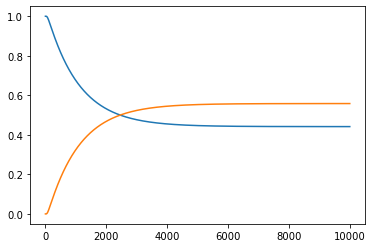

In [19]:
simulation = np.array(simulation)
# compute psi_squared
prob = np.abs(simulation)

# compute probability of finding particle on the left or right of the maximum
left_prob = prob[:, x<=0].sum(axis=1)*dx
right_prob = prob[:, x>0].sum(axis=1)*dx

# check if total prob is conserved
print('Probability conserved:', np.allclose(np.ones_like(left_prob), left_prob+right_prob))

plt.plot(times, left_prob)
plt.plot(times, right_prob)

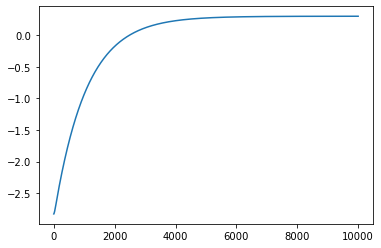

In [20]:
avg_x = np.sum(prob*x, axis=1)*dx
plt.plot(times, avg_x)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [12]:
V0(+x_s)/V0(-x_s)

1.3526385387735465

In [13]:
0.6/0.4

1.4999999999999998